In [1]:
import pandas as pd
import swifter
import re
import gc
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from string import digits
import gensim
from sklearn import preprocessing
import pymorphy2
from swifter import swifter
import pickle
morph = pymorphy2.MorphAnalyzer()

C:\Users\AlexConda\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from scipy import spatial

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])

In [4]:
def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = file_text.split(' ')

    #let's delete punctuation symbols
    tokens = [i for i in tokens if ( i not in string.punctuation )]

    #deleting stop_words без этого 85852
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if (i not in stop_words)]

    #cleaning words

    tokens = [morph.parse(i)[0].normal_form for i in tokens]
     
    return ' '.join(tokens)

In [5]:
def featurize_w2v(model, sentences, vsize=150):
    f = np.zeros((len(sentences), vsize))
    for i,s in enumerate(sentences):
        #count = 0.
        for w in s:
            try:
                vec = model[w].reshape((1, vsize))*tfidf[w]
                #count +=1.
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        if len(s) !=0: #count != 0:
            f[i,:] = f[i,:] / len(s)
    return f

In [6]:
def get_tfidf(texts):
    vectorizer = TfidfVectorizer(encoding='unicode',
                                                  ngram_range= (1, 1), 
                                                  norm=None,
                                                 #stop_words=stop_words,
                                                  #min_df=3,#3-оптимум
                                                  use_idf=True,
                                                  #sublinear_tf=True,
                                                  #tokenizer=TweetTokenizer().tokenize,
                                                  #stop_words=stop_words,
                                                  analyzer='word')
    matrix = vectorizer.fit_transform(texts)
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    return tfidf, matrix

### EDA

In [7]:
df=pd.read_csv('vk.csv', index_col=0)

In [8]:
#заменим пустые строки на символ пустой строки
df['question'].fillna('', inplace=True) 

In [9]:
#вычащаем символы
df['question']=df['question'].str.replace('(["№#$%&()*!?+,-./:;<=>@[\]^_`{|}~"“”¨«»®´·º½¾²¿¡§£₤‘’\t\n\d*])',' ') 

In [10]:
#убираем цифры
df['question']=df['question'].map(lambda x: re.sub(r'\d',' ', x.lower()))

In [11]:
#убрать латинские символы
df['question']=df['question'].map(lambda x: re.sub(r'[abcdefghijklmnopqrstuvwxyz]',' ', x.lower()))

In [12]:
#зафиксим "не"
df['question']=df['question'].map(lambda x: re.sub(r' не ',' не_', x.lower()))

In [13]:
#чистим от термов короче 3 символов
df['question']=df['question'].map(lambda x: ' '.join([st for st in x.split(' ') if st!='' and len(st)>3]))

In [14]:
#нормализуем данные
df['question']=df['question'].swifter.apply(lambda x: tokenize_me(x))

Pandas Apply: 100%|█████████████████████████████████████████████████████████████| 40117/40117 [02:33<00:00, 262.15it/s]


In [15]:
df['question'][1]

'дебетный карта пришлый сообщение неразрешенный задолженность никакой задолженность не_мочь карта дебетный сколько понять банковский косяк банк захотеть взять процент вернуть свой деньга'

### word2vec
    1.Обучим свой w2v на диалогах и возьмем гугловский w2v для русского языка.
    2.Эксперимент показал, что лучше работает w2v обученный именно на диалогах.

In [16]:
documents=list(df['question'].map(lambda x: [st for st in x.split(' ')])) #получим токен лист документов

In [17]:
w2v_model = pickle.load(open('word_vectors.pkl', "rb")) #пробовал работает хуже

In [17]:
model = gensim.models.Word2Vec(
        documents,
        size=300,
        window=5,
        min_count=1,
        workers=6)
model.train(documents, total_examples=len(documents), epochs=10)

(6060751, 7212920)

In [18]:
### ОБУЧИЛ СВОЙ w2v
gc.collect()

0

In [19]:
tfidf, _ = get_tfidf(df['question']) #TFIDF для того, чтобы информация после сложения векторов слов в предложения на размылось

In [20]:
documents=list(df['question'].map(lambda x: [st for st in x.split(' ') if st!='' and len(st)>3])) #подчистим слова имеющие менее 4 символов

In [21]:
w2v_train = featurize_w2v(model, documents, 300) #векторизуем вопросы

C:\Users\AlexConda\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [22]:
w2v_train

array([[ 0.76800202, -0.79295181,  0.79628135, ..., -0.20795913,
         3.75864571, -0.15927018],
       [ 0.57324352,  1.62459679, -0.05462   , ..., -0.69258693,
        -0.69549218, -0.95374401],
       [-1.64565914,  1.32632492, -0.69669094, ...,  0.72904774,
         0.017226  ,  1.15732627],
       ...,
       [ 0.29746139, -1.15482549,  2.74291831, ...,  1.06140679,
         1.43490343,  1.4336178 ],
       [ 1.48094589,  1.32346201, -1.43632933, ...,  1.3889812 ,
        -0.00398804,  0.60700192],
       [ 1.64399461,  1.90951513, -0.02743099, ..., -0.51850617,
        -0.12806366, -3.81865987]])

### Clustering
1. Попробуем для кластеризации использовать k-means
2. В качестве confidence возьмем именно дистанции до N ближайших кластеров
3. Для выделения тематик используем TF-IDF представления кластера-документа. Подход в том, чтобы объеденить обращения внутри кластера в один док и посчитать к нему tfidf топ 5 по этой мере слов и будет характеристикой кластера.
4. Число кластеров примем по правилу плеча (на изгибе кривой изменения инерции кластера по отношению к их числу на обучении)

In [23]:
from sklearn.cluster import MiniBatchKMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
w2v_train=preprocessing.scale(w2v_train)

In [25]:
%%time
inertia = []
#X_all_clear.drop(['yaS_labels'], axis=1, inplace=True)
for k in range(10, 310, 10):
    kmeans=MiniBatchKMeans(n_clusters=k, batch_size=1000, max_iter=100, tol=1e-4, random_state=42, n_init=4).fit(w2v_train)
    inertia.append(np.sqrt(kmeans.inertia_))

Wall time: 1min 52s


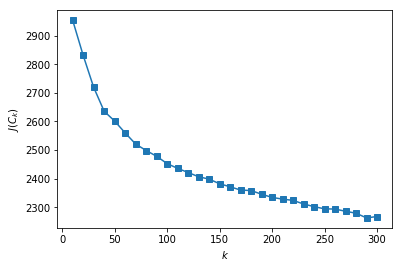

In [26]:
plt.plot(range(10, 310, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.show()

In [27]:
best_k=100
kmeans=MiniBatchKMeans(n_clusters=best_k, batch_size=1000, max_iter=100, tol=1e-4, random_state=42, n_init=4).fit(w2v_train)

In [28]:
df['cluster_labels']=[i for i in kmeans.labels_ ]

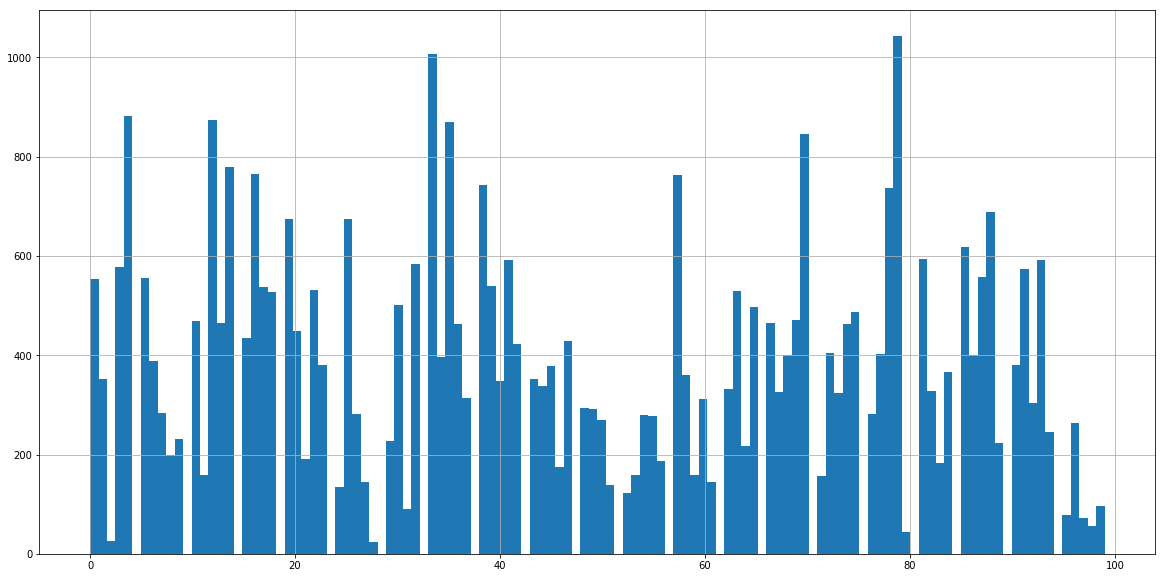

In [29]:
plt.figure(figsize=(20,10))
df['cluster_labels'].hist(bins=120)

In [30]:
#сохраним модель
pickle.dump(kmeans, open('kmeans_clustreing_k100.sav', 'wb'))

In [31]:
pickle.dump(model, open('w2v_cards_model.sav', 'wb'))

In [60]:
np.argsort(kmeans.transform([w2v_train[0]]))[0]

array([13, 43, 81, 93, 56, 15, 51, 74, 87, 30, 72, 17, 76, 35,  5, 12, 68,
       16, 49, 14, 79, 57, 78, 82, 50, 39, 22, 88, 25, 86, 41, 69, 84, 47,
       18, 37, 66,  1, 70,  3, 33, 10, 32, 63, 42, 53, 52, 23,  8,  6, 20,
       91,  4, 96, 99, 60, 45, 44, 89, 67,  0, 73, 85,  7, 19, 65, 36, 34,
       55, 40, 48, 26, 77, 90, 64, 92, 29, 75, 94, 38, 58, 59, 80, 62, 71,
       54, 83, 61, 31, 11, 27, 46, 95, 21, 97,  2, 98, 24, 28,  9],
      dtype=int64)

In [59]:
1-(np.sort(kmeans.transform([w2v_train[0]]))[0][:5]-np.min(kmeans.transform([w2v_train[0]])[0]))/(np.max(kmeans.transform([w2v_train[0]])[0])-np.min(kmeans.transform([w2v_train[0]])[0]))

array([1.        , 0.9401    , 0.87936709, 0.87497828, 0.86818809])

### Modeling thems

In [33]:
from sklearn.neighbors import NearestNeighbors

def get_top_term(n, i):
    return vocab[np.argsort(-1*np_descr.toarray()[i])[:n]]

In [34]:
df_descr=df[['question','cluster_labels']].groupby('cluster_labels',as_index=False).agg(lambda x:' '.join(x))

tfidf_= TfidfVectorizer(stop_words=stop_words, 
                        ngram_range=(1,1),
                        norm=None, 
                        use_idf=True,
                       smooth_idf =True
                       ).fit(df_descr['question'])


np_descr=tfidf_.transform(df_descr['question'])
vocab=np.array(tfidf_.get_feature_names())

In [35]:
df_descr['top5_descriptions_words']=''
for i in range(df_descr.shape[0]):
    print('cluster_labels', df_descr['cluster_labels'][i])
    print(get_top_term(5, i))
    df_descr['top5_descriptions_words'].iloc[i]=get_top_term(5, i)

cluster_labels 0
['документ' 'кредит' 'сбербанк' 'банка' 'договор']


C:\Users\AlexConda\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


cluster_labels 1
['баланс' 'карта' 'деньга' 'рубль' 'пополнить']
cluster_labels 2
['заблокировать' 'блокировать' 'мошенник' 'написывать' 'доступ']
cluster_labels 3
['арест' 'пристав' 'карта' 'деньга' 'счёт']
cluster_labels 4
['сбербанк' 'карта' 'сотрудник' 'банка' 'вопрос']
cluster_labels 5
['комиссия' 'карта' 'перевод' 'сбербанк' 'деньга']
cluster_labels 6
['паспорт' 'карта' 'получить' 'мочь' 'документ']
cluster_labels 7
['город' 'карта' 'открытый' 'область' 'регион']
cluster_labels 8
['монета' 'сбербанк' 'купить' 'юбилейный' 'номинал']
cluster_labels 9
['мошенник' 'аааа' 'подство' 'подстверждение' 'подстановка']
cluster_labels 10
['карта' 'готовый' 'забрать' 'сказать' 'неделя']
cluster_labels 11
['кредит' 'потребительский' 'взять' 'тысяча' 'процент']
cluster_labels 12
['карта' 'сбербанк' 'отделение' 'сказать' 'банка']
cluster_labels 13
['карта' 'магазин' 'интернет' 'покупка' 'оплата']
cluster_labels 14
['карта' 'деньга' 'заблокировать' 'снять' 'счёт']
cluster_labels 15
['курс' 'долла

In [ ]:
del(vocab)
gc.collect()

In [51]:
df#.drop(['top5_descriptions_words_x','top5_descriptions_words_y'], axis=1, inplace=True)

,question,answer,cluster_labels,top5_descriptions_words
0,кредитный карта моментум расплачиваться зарубе...,"вы можете, использовать кредитую карту visa/...",13,"[карта, магазин, интернет, покупка, оплата]"
1,дебетный карта пришлый сообщение неразрешенный...,по данному вопросу вы можете обратиться в сл...,3,"[арест, пристав, карта, деньга, счёт]"
2,вопрос почему не_приходить пополнение карта ра...,по данному вопросу вы можете обратиться в сл...,57,"[мобильный, банк, подключить, карта, отключить]"
3,зарплатный карта пользоваться сбол кроме перев...,по данному вопросу вы можете обратиться в сл...,35,"[карта, сбербанк, счёт, деньга, перевод]"
4,здраствовать пришлый одобрить предворительный ...,потребительский кредит может быть выдан при ...,62,"[кредит, доход, стаж, взять, справка]"
5,заканчиваться срок действие карта быстро обмен...,"александр, карта действует до последнего чи...",42,"[карта, срок, действие, заканчиваться, истечь]"
6,долго разблокировать карта обращение банк,сроки разблокировки карты вы можете уточнить...,58,"[обращение, ответ, рассмотрение, заявление, пр..."
7,сбербанк онлайн личный кабинет главный страниц...,на странице пенсионный фонд вы можете просмо...,35,"[карта, сбербанк, счёт, деньга, перевод]"
8,неподсказать курс золото сегодня,ознакомиться с котировкой драгоценных металл...,15,"[курс, доллар, валюта, карта, конвертация]"
9,уточнить пожалуйста адрес электронный почта мо...,оставить ваше обращение вы можете на сайте с...,58,"[обращение, ответ, рассмотрение, заявление, пр..."


In [48]:
df=df.merge(df_descr[['cluster_labels','top5_descriptions_words']], how='left', on='cluster_labels')

In [52]:
vk_data=pd.read_csv('vk.csv', index_col=0)

In [53]:
vk_data['cluster_labels']=df['cluster_labels']
vk_data['top5_descriptions_words']=df['top5_descriptions_words']

In [81]:
#создадим базу тем
(df[['cluster_labels','top5_descriptions_words']].sort_values(by='cluster_labels')['top5_descriptions_words'].drop_duplicates().reset_index()).to_json('themes_base.json', orient='records')

In [54]:
vk_data.to_csv('vk.csv')

In [148]:
kmeans.predict([w2v_train[40097]])[0]

40

### LDA gensim
1. Идея для soft кластеризации через LDA|LSI
2. Попробовал, но перплексия такая себе

In [41]:
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from pprint import pprint

In [46]:
id2word = corpora.Dictionary(list(df['question'].str.split()))

In [50]:
common_corpus = [id2word.doc2bow(text) for text in list(df['question'].str.split())]

In [60]:
# Train the model on the corpus.
lda = models.ldamodel.LdaModel(corpus=common_corpus,
                                           id2word=id2word,
                                           num_topics=200, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [61]:
pprint(lda.print_topics())

[(78,
  '0.193*"свободный" + 0.154*"питер" + 0.092*"пинкод" + 0.066*"нуль" + '
  '0.065*"отключать" + 0.046*"не_туда" + 0.035*"хоум" + 0.027*"признательный" '
  '+ 0.021*"сперва" + 0.019*"питерский"'),
 (116,
  '0.176*"восстановление" + 0.172*"практика" + 0.140*"контора" + '
  '0.119*"единственный" + 0.088*"отвязать" + 0.042*"эквайринг" + '
  '0.026*"волновать" + 0.025*"хотеть" + 0.018*"не_обнаружить" + '
  '0.012*"делать"'),
 (80,
  '0.168*"именной" + 0.165*"придумать" + 0.074*"карта" + 0.064*"норма" + '
  '0.052*"вообщий" + 0.050*"четверг" + 0.035*"нулевой" + '
  '0.032*"территориальный" + 0.030*"учитывать" + 0.028*"волгоград"'),
 (143,
  '0.161*"пять" + 0.154*"выплачивать" + 0.115*"работодатель" + '
  '0.077*"неизвестно" + 0.072*"скорый" + 0.037*"защитить" + 0.037*"закрой" + '
  '0.025*"событие" + 0.024*"бог" + 0.021*"не_идти"'),
 (118,
  '0.128*"оформляться" + 0.109*"чужой" + 0.104*"устроиться" + '
  '0.100*"присылать" + 0.040*"владимир" + 0.039*"сбербанк" + 0.038*"отследить" '
  '

In [62]:
coherence_model_lda = CoherenceModel(model=lda, texts=list(df['question'].str.split()), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [63]:
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41379266270000187
